In [1]:
import torchvision
import torch
import torchvision.transforms.functional as F
from torchvision.datasets import VOCDetection
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

c:\Users\DHAIRYA\.conda\envs\cv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
CLASS_TO_IDX = {cls: i for i, cls in enumerate(VOC_CLASSES)}

In [3]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, year="2007", image_set="trainval"):
        self.dataset = VOCDetection(root, year=year, image_set=image_set, download=True)

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        img = F.to_tensor(img)

        objs = target["annotation"]["object"]
        if not isinstance(objs, list):
            objs = [objs]

        boxes, labels = [], []
        for obj in objs:
            bbox = obj["bndbox"]
            box = [int(bbox["xmin"]), int(bbox["ymin"]), int(bbox["xmax"]), int(bbox["ymax"])]
            boxes.append(box)
            labels.append(CLASS_TO_IDX[obj["name"]])

        target_dict = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }
        return img, target_dict

    def __len__(self):
        return len(self.dataset)

In [4]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [5]:
@torch.no_grad()
def evaluate_model(model, dataloader, device):
    model.eval()
    metric_map = MeanAveragePrecision()
    all_tp = all_fp = all_fn = correct = total = 0

    for images, targets in tqdm(dataloader, desc="Evaluating"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        preds = model(images)

        metric_map.update(preds, targets)

        for pred, target in zip(preds, targets):
            pred_labels = pred['labels']
            true_labels = target['labels']
            pred_set = set(pred_labels.cpu().numpy())
            true_set = set(true_labels.cpu().numpy())

            tp = len(pred_set & true_set)
            fp = len(pred_set - true_set)
            fn = len(true_set - pred_set)

            all_tp += tp
            all_fp += fp
            all_fn += fn
            correct += sum([1 for pl in pred_labels if pl in true_labels])
            total += len(true_labels)

    map_results = metric_map.compute()
    precision = all_tp / (all_tp + all_fp + 1e-6)
    recall = all_tp / (all_tp + all_fn + 1e-6)
    accuracy = correct / (total + 1e-6)

    print("\n--- Evaluation Metrics ---")
    print(f"mAP (IoU=0.5:0.95): {map_results['map']:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    return map_results

In [6]:
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_set = VOCDataset("./data", year="2007", image_set="trainval")
    test_set = VOCDataset("./data", year="2007", image_set="test")

    train_loader = DataLoader(train_set, batch_size=2, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_set, batch_size=2, shuffle=False, collate_fn=collate_fn)

    # Load model
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # Freeze backbone initially
    for param in model.backbone.body.parameters():
        param.requires_grad = False

    # Unfreeze deeper layers
    for name, param in model.backbone.body.named_parameters():
        if "layer3" in name or "layer4" in name:
            param.requires_grad = True

    model.to(device)

    # Optimizer on unfrozen params only
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # Training loop
    model.train()
    for epoch in range(5):
        running_loss = 0
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch + 1} Average Loss: {running_loss / len(train_loader):.4f}")

    torch.save(model.state_dict(), "fasterrcnn_resnet50_voc.pth")
    print("✅ Model training complete and saved.")
    evaluate_model(model, test_loader, device)

In [7]:
import random
from torchvision.utils import draw_bounding_boxes

IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}

def visualize(model_path="fasterrcnn_resnet50_voc.pth", idx=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Load VOC test dataset
    dataset = VOCDetection("./data", year="2007", image_set="test", download=False)

    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    img_pil, _ = dataset[idx]
    img_tensor = F.to_tensor(img_pil).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        prediction = model(img_tensor)[0]

    boxes = prediction["boxes"].cpu()
    labels = prediction["labels"].cpu()
    scores = prediction["scores"].cpu()

    # Filter low scores
    threshold = 0.5
    keep = scores > threshold
    boxes = boxes[keep]
    labels = labels[keep]

    # Prepare label text
    label_names = [f"{IDX_TO_CLASS[label.item()]}" for label in labels]

    # Draw boxes
    drawn = draw_bounding_boxes(
        (img_tensor[0].cpu() * 255).byte(),
        boxes=boxes,
        labels=label_names,
        colors="red",
        width=2,
        font_size=18
    )

    # Show image
    plt.figure(figsize=(10, 10))
    plt.imshow(drawn.permute(1, 2, 0))
    plt.title(f"Predictions on VOC image #{idx}")
    plt.axis("off")
    plt.show()

In [12]:
def load_model(weights_path, device):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [14]:
from PIL import Image
def annotate_frame(model, frame, device, threshold=0.5):
    img_tensor = F.to_tensor(Image.fromarray(frame)).unsqueeze(0).to(device)
    with torch.no_grad():
        preds = model(img_tensor)[0]

    boxes = preds["boxes"].cpu()
    labels = preds["labels"].cpu()
    scores = preds["scores"].cpu()

    keep = scores > threshold
    boxes = boxes[keep]
    labels = labels[keep]

    label_names = [IDX_TO_CLASS[label.item()] for label in labels]

    annotated = draw_bounding_boxes(
        (img_tensor[0].cpu() * 255).byte(),
        boxes=boxes,
        labels=label_names,
        colors="green",
        width=2,
        font_size=16
    )

    return annotated.permute(1, 2, 0).numpy()

In [ ]:
import cv2
def process_video(input_path, output_path, model, device):
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Processing {frame_count} frames...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        annotated = annotate_frame(model, rgb_frame, device)
        annotated_bgr = cv2.cvtColor(annotated, cv2.COLOR_RGB2BGR)

        out.write(annotated_bgr)

    cap.release()
    out.release()
    print(f"Video saved to {output_path}")

In [16]:
if __name__ == "__main__":
    # train()
    # visualize(model_path="fasterrcnn_resnet50_voc.pth", idx=200)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_path = "fasterrcnn_resnet50_voc.pth"
    input_video = "input.mp4"         # Replace with your video path
    output_video = "output.mp4"       # Output annotated video path

    model = load_model(model_path, device)
    process_video(input_video, output_video, model, device)

Processing 910 frames...
✅ Video saved to output.mp4


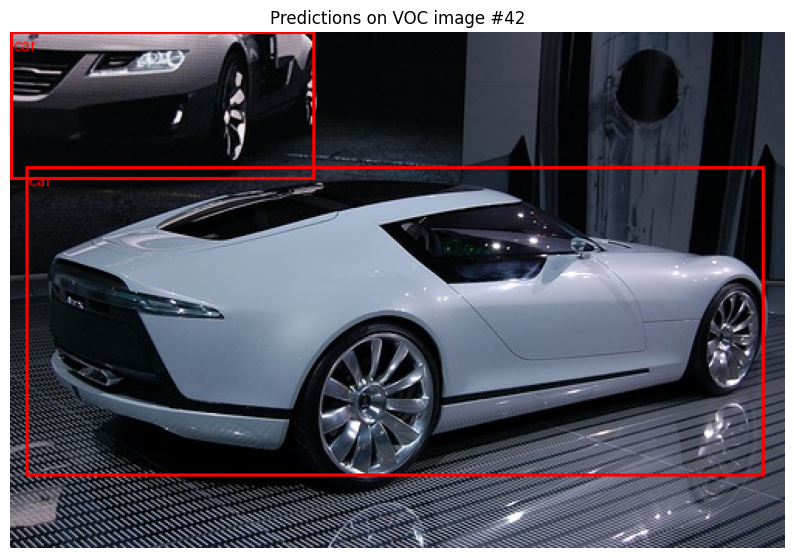

In [18]:
visualize(model_path="fasterrcnn_resnet50_voc.pth", idx=42)